# RNN Build


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 256)         247296    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 64)     64000       ['input_1[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 64)     128000      ['input_2[0][0]']                
                                                                                              

In [ ]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()

In [ ]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 128)           38400     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


# LSTM Demo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
## 设置字体
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "/Library/Fonts/华文细黑.ttf",size=14)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:

fonts = FontProperties(fname = "/System/Library/Fonts/STHeiti Medium.ttc",size=14)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/cnews-LSTM/cnews_train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/cnews-LSTM/cnews_val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/cnews-LSTM/cnews_test.csv")
train_df.head()

,label,text,cutword,cutwordnum
0,体育,马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...,马晓旭 意外 受伤 国奥 警惕 无奈 大雨 格外 青睐 殷家 记者 傅亚雨 沈阳 报道 来到...,259
1,体育,商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...,商瑞华 首战 复仇 心切 中国 玫瑰 美国 方式 攻克 瑞典 多曼来 瑞典 商瑞华 首战 信...,526
2,体育,冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...,冠军 球队 迎新 欢乐 派对 黄旭获 大奖 张军 PK 新浪 体育讯 12 27 日晚 冠军...,610
3,体育,辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...,辽足 签约 危机 注册 难关 高层 威逼利诱 合同 笑里藏刀 新浪 体育讯 24 辽足 爆发...,524
4,体育,揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道 谢亚龙已经被公安...,揭秘 谢亚龙 带走 总局 电话 骗局 复制 南杨 轨迹 体坛周报 特约记者 张锐 北京 报道...,282


In [ ]:
driving_df = pd.read_csv("/content/drive/MyDrive/outputs_driving.csv",index_col = False)
legal_df = pd.read_csv("/content/drive/MyDrive/outputs_legal.csv",index_col = False)

driving_texts = driving_df.values.tolist()
driving_texts = [[word for word in text if not str(word)=='nan'] for text in driving_texts]
print(driving_texts[0:10])

legal_texts = legal_df.values.tolist()
legal_texts = [[word for word in text if not str(word)=='nan'] for text in legal_texts]
print(legal_texts[0:10])


[['beyond', 'knowledge', 'technology', 'driving', 'age', 'consciousness', 'ai', 'ethics', 'via'], ['took', 'self', 'driving', 'car', 'test', 'via', 'moralmachine', 'trolleyproblem', 'morality', 'ai', 'ethics', 'moralmachine', 'net', 'moral', 'machine', 'platform', 'public', 'participation', 'discussion', 'human', 'perspective', 'machine', 'made', 'moral', 'decisions'], ['john', 'deere', 'self', 'driving', 'tractor', 'stirs', 'debate', 'ai', 'farming', 'wired', 'datascience', 'aiethics', 'robotics', 'john', 'deere', 'self', 'driving', 'tractor', 'stirs', 'debate', 'ai', 'farming', 'automation', 'control', 'resulting', 'data', 'raises', 'questions', 'role', 'human', 'farmers'], ['future', 'ai', 'hold', 'shares', 'five', 'predictions', 'covering', 'language', 'models', 'autonomous', 'driving', 'conversations', 'around', 'ai', 'ethics', 'top', 'predictions', 'ai', 'deepmind', 'tesla', 'openai'], ['future', 'ai', 'hold', 'shares', 'five', 'predictions', 'covering', 'language', 'models', 'au

In [ ]:
labels = ['driving'] * len(driving_texts) + ['legal'] * len(legal_texts)
print(labels)
print(len(driving_texts))
print(len(legal_texts))

['driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving', 'driving'

In [ ]:
texts = driving_texts + legal_texts
data = pd.DataFrame({'texts':texts, 'labels':labels})
data.head()

,texts,labels
0,"[beyond, knowledge, technology, driving, age, ...",driving
1,"[took, self, driving, car, test, via, moralmac...",driving
2,"[john, deere, self, driving, tractor, stirs, d...",driving
3,"[future, ai, hold, shares, five, predictions, ...",driving
4,"[future, ai, hold, shares, five, predictions, ...",driving


In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)
data.head()

,texts,labels
312,"[ai, startups, finally, getting, onboard, ai, ...",driving
1233,"[completely, agree, looking, ai, cars, easy, t...",legal
1489,"[trending, legal, strategic, visions, ethics, ...",legal
716,"[interesting, interview, industry, capture, cs...",driving
1102,"[article, stanford, launches, ai, audit, chall...",legal


In [ ]:
train_data = data.sample(frac = 0.8, random_state = 0, axis = 0)
train_data.head()

,texts,labels
1357,"[legal, personhood, ai, taking, sneaky, path, ...",legal
1049,"[twitter, ai, ethics, director, locked, legal,...",legal
1289,"[ai, law, ai, ethics, giving, thumbs, ai, snif...",legal
121,"[self, driving, car, kill, baby, grandma, depe...",driving
13,"[latest, jolting, ai, ethics, concern, ai, ine...",driving


In [ ]:
test_data = data[~data.index.isin(train_data)]
test_data.head()

,texts,labels
312,"[ai, startups, finally, getting, onboard, ai, ...",driving
1233,"[completely, agree, looking, ai, cars, easy, t...",legal
1489,"[trending, legal, strategic, visions, ethics, ...",legal
716,"[interesting, interview, industry, capture, cs...",driving
1102,"[article, stanford, launches, ai, audit, chall...",legal


In [ ]:
## 对数据集的标签数据进行编码
train_y = train_data.labels
test_y = test_data.labels
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1,1)
test_y = le.transform(test_y).reshape(-1,1)

## 对数据集的标签数据进行one-hot编码
ohe = OneHotEncoder()
train_y = ohe.fit_transform(train_y).toarray()
test_y = ohe.transform(test_y).toarray()

In [ ]:
## 使用Tokenizer对词组进行编码
## 当我们创建了一个Tokenizer对象后，使用该对象的fit_on_texts()函数，以空格去识别每个词,
## 可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小。
max_words = 5000
max_len = 60
tok = Tokenizer(num_words=max_words)  ## 使用的最大词语数为5000
tok.fit_on_texts(train_data.texts)

## 使用word_index属性可以看到每次词对应的编码
## 使用word_counts属性可以看到每个词对应的频数
for ii,iterm in enumerate(tok.word_index.items()):
    if ii < 10:
        print(iterm)
    else:
        break
print("===================")
for ii,iterm in enumerate(tok.word_counts.items()):
    if ii < 10:
        print(iterm)
    else:
        break

('ai', 1)
('ethics', 2)
('legal', 3)
('driving', 4)
('self', 5)
('cars', 6)
('including', 7)
('autonomous', 8)
('ethical', 9)
('aiethics', 10)
('legal', 1057)
('personhood', 81)
('ai', 4370)
('taking', 31)
('sneaky', 28)
('path', 33)
('makes', 31)
('law', 245)
('ethics', 1777)
('nervous', 24)


In [ ]:
from keras.utils import pad_sequences
## 对每个词编码之后，每句新闻中的每个词就可以用对应的编码表示，即每条新闻可以转变成一个向量了：
train_seq = tok.texts_to_sequences(train_data.texts)
test_seq = tok.texts_to_sequences(test_data.texts)
## 将每个序列调整为相同的长度
train_seq_mat = pad_sequences(train_seq,maxlen=max_len)
test_seq_mat = pad_sequences(test_seq,maxlen=max_len)

print(train_seq_mat.shape)
print(test_seq_mat.shape)

(1197, 60)
(1496, 60)


In [ ]:
## 定义LSTM模型
inputs = Input(name='inputs',shape=[max_len])
## Embedding(词汇表大小,batch大小,每个新闻的词长)
layer = Embedding(max_words+1,128,input_length=max_len)(inputs)
layer = LSTM(128)(layer)
layer = Dense(128,activation="relu",name="FC1")(layer)
layer = Dropout(0.5)(layer)
layer = Dense(2,activation="softmax",name="FC2")(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 60)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 60, 128)           640128    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 FC1 (Dense)                 (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 FC2 (Dense)                 (None, 2)                 258       
                                                                 
Total params: 788,482
Trainable params: 788,482
Non-trainab

In [ ]:
## 模型训练
model_fit = model.fit(train_seq_mat,train_y,batch_size=32,epochs=10,
                      validation_data=(test_seq_mat,test_y),
                      callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)] ## 当val-loss不再提升时停止训练
                     )

Epoch 1/10
38/38 [==============================] - 1s 14ms/step - loss: 0.0835 - accuracy: 0.9515 - val_loss: 0.0956 - val_accuracy: 0.9512
Epoch 2/10
38/38 [==============================] - 1s 13ms/step - loss: 0.0834 - accuracy: 0.9490 - val_loss: 0.2207 - val_accuracy: 0.9492


In [ ]:
s1 = 'Self driving car is a disaster to society! Ai Ethics should be considered while developing ai prodocts!'
s2 = 'The legistration problem for ai needs more discussion'
s3 = 'who should be responsibel for ai ethics? if a car crashed on someone with auto driving, who should be responsibel from the perspective of laws?'

s1_words = s1.split(' ')
s2_words = s1.split(' ')
s3_words = s1.split(' ')
val_text = [s1_words, s2_words, s3_words]
val_labels = ['driving', 'legal', 'legal']

val_data = pd.DataFrame({'texts':val_text, 'labels':val_labels})
val_data.head()

,texts,labels
0,"[Self, driving, car, is, a, disaster, to, soci...",driving
1,"[Self, driving, car, is, a, disaster, to, soci...",legal
2,"[Self, driving, car, is, a, disaster, to, soci...",legal


In [ ]:
## 对数据集的标签数据进行编码
val_y = val_data.labels
le = LabelEncoder()
val_y = le.fit_transform(val_y).reshape(-1,1)

## 对数据集的标签数据进行one-hot编码
ohe = OneHotEncoder()
val_y = ohe.fit_transform(val_y).toarray()

In [ ]:
## 对每个词编码之后，每句新闻中的每个词就可以用对应的编码表示，即每条新闻可以转变成一个向量了：
val_seq = tok.texts_to_sequences(val_data.texts)
## 将每个序列调整为相同的长度
val_seq_mat = pad_sequences(val_seq,maxlen=max_len)

print(val_seq_mat.shape)

(3, 60)


1/1 [==============================] - 0s 18ms/step


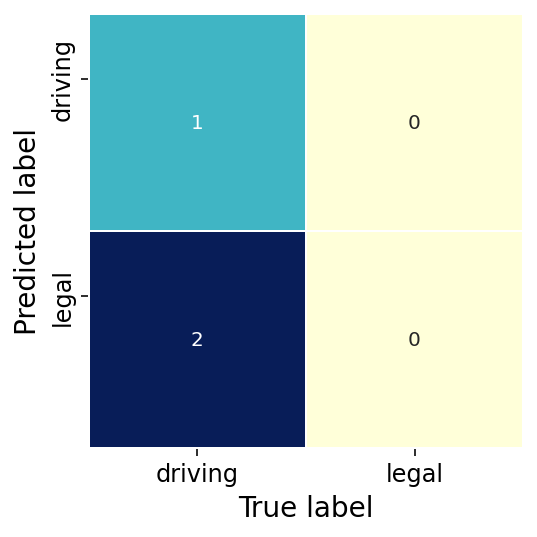

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.00      0.00      0.00         0

    accuracy                           0.33         3
   macro avg       0.50      0.17      0.25         3
weighted avg       1.00      0.33      0.50         3



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## 对测试集进行预测

val_pre = model.predict(val_seq_mat)

## 评价预测效果，计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(val_pre,axis=1),np.argmax(val_y,axis=1))
## 混淆矩阵可视化
Labname = ["driving","legal"]
plt.figure(figsize=(4,4))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False,linewidths=.8,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.xticks(np.arange(2)+0.5,Labname,size = 12)
plt.yticks(np.arange(2)+0.3,Labname,size = 12)
plt.show()


print(metrics.classification_report(np.argmax(val_pre,axis=1),np.argmax(val_y,axis=1)))

# DEMO used for THUCNews

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


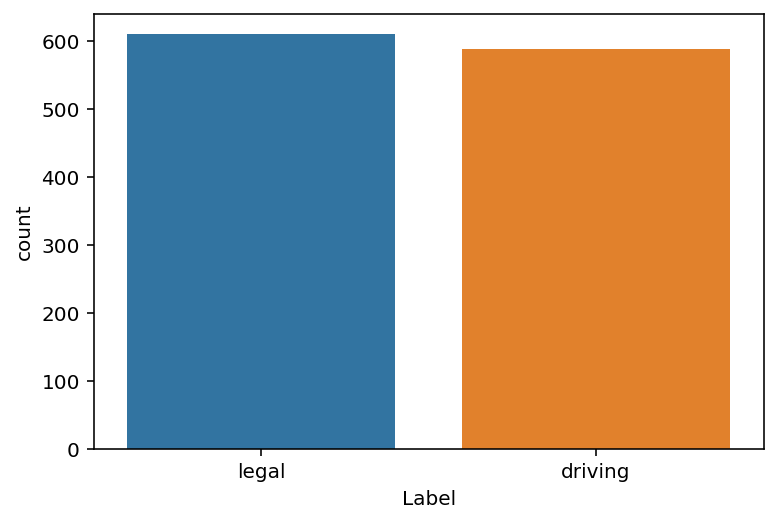

In [ ]:
## 查看训练集都有哪些标签
plt.figure()
sns.countplot(train_data.labels)
plt.xlabel('Label',size = 10)
plt.xticks(size = 10)
plt.show()

count    50000.000000
mean       300.462240
std        304.555855
min          4.000000
25%        115.000000
50%        226.000000
75%        382.000000
max       9083.000000
Name: cutwordnum, dtype: float64


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35757 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32451 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38598 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35789 missing from current font.
  font.set_

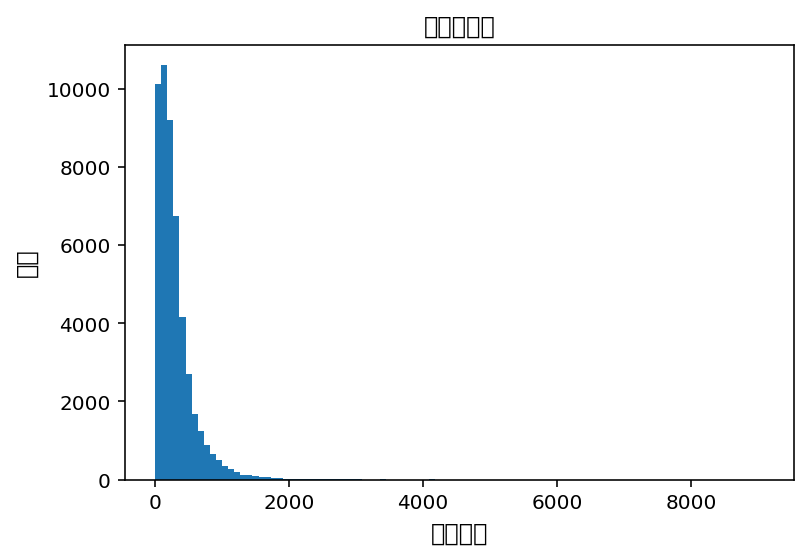

In [ ]:
print(train_df.cutwordnum.describe())
plt.figure()
plt.hist(train_df.cutwordnum,bins=100)
plt.xlabel("词组长度",size = 12)
plt.ylabel("频数",size = 12)
plt.title("训练数据集")
plt.show()

In [ ]:
## 对数据集的标签数据进行编码
train_y = train_df.label
val_y = val_df.label
test_y = test_df.label
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1,1)
val_y = le.transform(val_y).reshape(-1,1)
test_y = le.transform(test_y).reshape(-1,1)

## 对数据集的标签数据进行one-hot编码
ohe = OneHotEncoder()
train_y = ohe.fit_transform(train_y).toarray()
val_y = ohe.transform(val_y).toarray()
test_y = ohe.transform(test_y).toarray()

In [ ]:
## 使用Tokenizer对词组进行编码
## 当我们创建了一个Tokenizer对象后，使用该对象的fit_on_texts()函数，以空格去识别每个词,
## 可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小。
max_words = 5000
max_len = 600
tok = Tokenizer(num_words=max_words)  ## 使用的最大词语数为5000
tok.fit_on_texts(train_df.cutword)

## 使用word_index属性可以看到每次词对应的编码
## 使用word_counts属性可以看到每个词对应的频数
for ii,iterm in enumerate(tok.word_index.items()):
    if ii < 10:
        print(iterm)
    else:
        break
print("===================")
for ii,iterm in enumerate(tok.word_counts.items()):
    if ii < 10:
        print(iterm)
    else:
        break

('我们', 1)
('一个', 2)
('中国', 3)
('可以', 4)
('基金', 5)
('没有', 6)
('自己', 7)
('他们', 8)
('市场', 9)
('这个', 10)
('马晓旭', 2)
('意外', 1641)
('受伤', 1948)
('国奥', 148)
('警惕', 385)
('无奈', 1161)
('大雨', 77)
('格外', 529)
('青睐', 1092)
('殷家', 1)


In [ ]:
## 对每个词编码之后，每句新闻中的每个词就可以用对应的编码表示，即每条新闻可以转变成一个向量了：
train_seq = tok.texts_to_sequences(train_df.cutword)
val_seq = tok.texts_to_sequences(val_df.cutword)
test_seq = tok.texts_to_sequences(test_df.cutword)
## 将每个序列调整为相同的长度
train_seq_mat = pad_sequences(train_seq,maxlen=max_len)
val_seq_mat = pad_sequences(val_seq,maxlen=max_len)
test_seq_mat = pad_sequences(test_seq,maxlen=max_len)

print(train_seq_mat.shape)
print(val_seq_mat.shape)
print(test_seq_mat.shape)

(50000, 600)
(5000, 600)
(10000, 600)


In [ ]:
from keras.utils import pad_sequences

In [ ]:
## 定义LSTM模型
inputs = Input(name='inputs',shape=[max_len])
## Embedding(词汇表大小,batch大小,每个新闻的词长)
layer = Embedding(max_words+1,128,input_length=max_len)(inputs)
layer = LSTM(128)(layer)
layer = Dense(128,activation="relu",name="FC1")(layer)
layer = Dropout(0.5)(layer)
layer = Dense(10,activation="softmax",name="FC2")(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 600)]             0         
                                                                 
 embedding (Embedding)       (None, 600, 128)          640128    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 FC1 (Dense)                 (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 FC2 (Dense)                 (None, 10)                1290      
                                                                 
Total params: 789,514
Trainable params: 789,514
Non-trainable

In [ ]:
## 模型训练
model_fit = model.fit(train_seq_mat,train_y,batch_size=128,epochs=10,
                      validation_data=(val_seq_mat,val_y),
                      callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)] ## 当val-loss不再提升时停止训练
                     )

Epoch 1/10
391/391 [==============================] - 30s 55ms/step - loss: 0.6828 - accuracy: 0.7964 - val_loss: 0.3620 - val_accuracy: 0.9016
Epoch 2/10
391/391 [==============================] - 21s 55ms/step - loss: 0.2494 - accuracy: 0.9407 - val_loss: 0.3643 - val_accuracy: 0.9120


313/313 [==============================] - 10s 31ms/step


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20307 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32946 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23089 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20048 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23478 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23621 missing from current font.
  font.set_

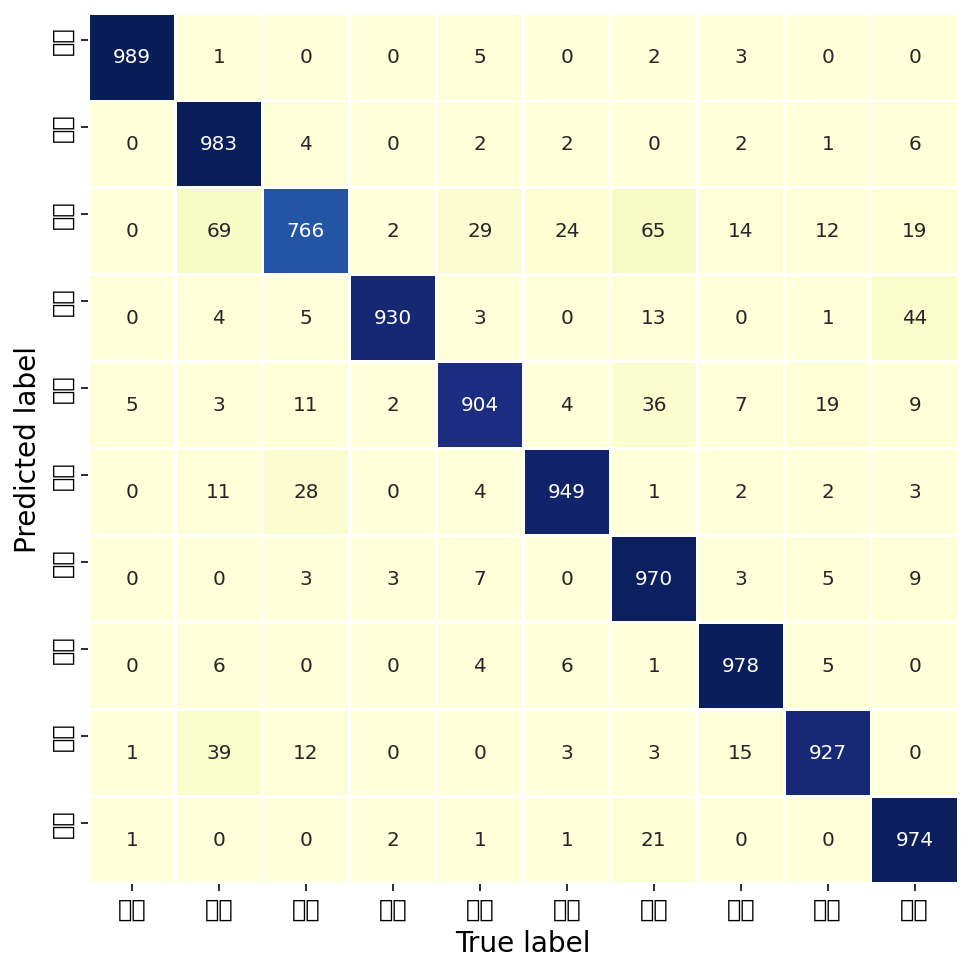

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       996
           1       0.98      0.88      0.93      1116
           2       0.77      0.92      0.84       829
           3       0.93      0.99      0.96       939
           4       0.90      0.94      0.92       959
           5       0.95      0.96      0.95       989
           6       0.97      0.87      0.92      1112
           7       0.98      0.96      0.97      1024
           8       0.93      0.95      0.94       972
           9       0.97      0.92      0.94      1064

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [ ]:
## 对测试集进行预测
test_pre = model.predict(test_seq_mat)

## 评价预测效果，计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1))
## 混淆矩阵可视化
Labname = ["体育","娱乐","家居","房产","教育","时尚","时政","游戏","科技","财经"]
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False,linewidths=.8,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.xticks(np.arange(10)+0.5,Labname,size = 12)
plt.yticks(np.arange(10)+0.3,Labname,size = 12)
plt.show()


print(metrics.classification_report(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1)))


In [ ]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(train_df.cutword)

In [ ]:
## 保存训练好的Tokenizer，和导入
import pickle
# saving
with open('tok.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tok.pickle', 'rb') as handle:
    tok = pickle.load(handle)